In [ ]:
# !nvidia-smi

In [2]:
import tensorflow as tf
import numpy as np
import os
import sys
import cv2
import pickle
import random
import pandas as pd

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten,Conv2D,MaxPooling2D,BatchNormalization, Lambda

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

# ***VGG 16***

In [3]:
IMAGE_SIZE = [224, 224]

In [4]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

mobilnet = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in mobilnet.layers:
  layer.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [5]:
x = Flatten()(mobilnet.output)
x1 = Dense(32, activation='relu')(x)
prediction = Dense(2, activation='sigmoid')(x1)

model = Model(inputs=mobilnet.input, outputs=prediction)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [7]:
datagen = ImageDataGenerator(rescale= 1./255,
                            rotation_range=45,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            validation_split = 0.25)

In [8]:
training_set = datagen.flow_from_directory('Pan_Pata/Train_S',
                                     target_size = (224,224),
                                     class_mode = 'categorical',
                                     subset='training')

test_set  = datagen.flow_from_directory('Pan_Pata/Train_S', 
                                      target_size = (224,224),
                                      class_mode = 'categorical',
                                      subset='validation')

Found 3851 images belonging to 2 classes.
Found 1283 images belonging to 2 classes.


In [ ]:
hist = model.fit_generator(
       training_set,
       validation_data=test_set,
       epochs=15,
       steps_per_epoch=len(training_set),
       validation_steps=len(test_set),
       callbacks = [early_stop])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/15
121/121 [==============================] - 838s 7s/step - loss: 0.5443 - accuracy: 0.7523 - val_loss: 0.4294 - val_accuracy: 0.7670
Epoch 2/15
121/121 [==============================] - 86s 715ms/step - loss: 0.3035 - accuracy: 0.8782 - val_loss: 0.3875 - val_accuracy: 0.8067
Epoch 3/15
121/121 [==============================] - 87s 723ms/step - loss: 0.2962 - accuracy: 0.8735 - val_loss: 0.3227 - val_accuracy: 0.8285
Epoch 4/15
121/121 [==============================] - 87s 717ms/step - loss: 0.2312 - accuracy: 0.9052 - val_loss: 0.3237 - val_accuracy: 0.8558
Epoch 5/15
121/121 [==============================] - 87s 718ms/step - loss: 0.2223 - accuracy: 0.9107 - val_loss: 0.2890 - val_accuracy: 0.8644
Epoch 6/15
121/121 [==============================] - 87s 721ms/step - loss: 0.1968 - accuracy: 0.9224 - val_loss: 0.2894 - val_accuracy: 0.8683
Epoch 7/15
121/121 [==============================] - 87s 720ms/step - loss: 0.1962 - accuracy: 0.9200 - val_loss: 0.2834 - val_accu

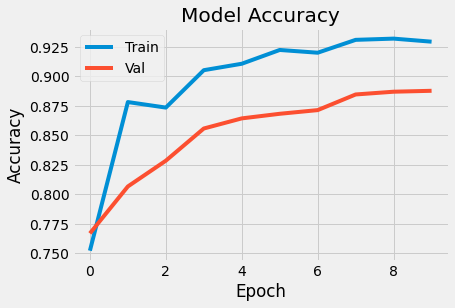

In [13]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

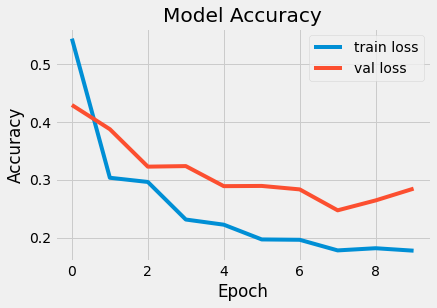

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

In [15]:
testt_datagen = ImageDataGenerator(rescale=1. / 255)

In [16]:
testt_generator = testt_datagen.flow_from_directory( 'Pan_Pata/Test',
                                              target_size = (224,224),
                                              class_mode='categorical',
                                              shuffle=False)

Found 658 images belonging to 2 classes.


In [17]:
score = model.evaluate_generator(testt_generator, 658)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [18]:
print("Accuracy = ",score)

Accuracy =  [0.18558306992053986, 0.9224923849105835]


In [19]:
pred = model.predict_generator(testt_generator, 658)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [22]:
y_true=testt_generator.classes

In [23]:
y_pred_vgg16=np.argmax(pred, axis=1)

In [24]:
from sklearn.metrics import classification_report
target_names = ['class 0(Benificial)', 'class 1(Harmful)']
print(classification_report(y_true, y_pred_vgg16, target_names=target_names))

                     precision    recall  f1-score   support

class 0(Benificial)       0.90      0.95      0.92       329
   class 1(Harmful)       0.94      0.90      0.92       329

           accuracy                           0.92       658
          macro avg       0.92      0.92      0.92       658
       weighted avg       0.92      0.92      0.92       658



In [25]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred_vgg16))

[[311  18]
 [ 33 296]]


In [26]:
from sklearn.metrics import roc_curve, auc

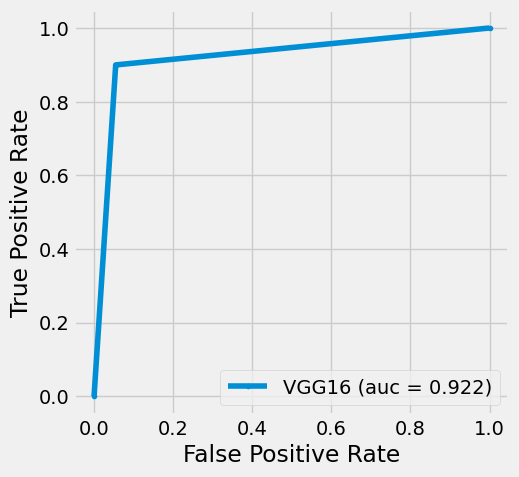

In [29]:
logistic_fpr, logistic_tpr, threshold = roc_curve(y_true, y_pred_vgg16)
auc_logistic = auc(logistic_fpr, logistic_tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='VGG16 (auc = %0.3f)' % auc_logistic)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.show()